# Bootstraps of network statistics on deg. preserved randomised networks
Randomises the adjacency matrices and returns diameter, transitivity etc

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import networkx.algorithms.community as nx_comm

import random 
from collections import Counter
from scipy import stats
import pickle as pkl
import math



import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
from mpl_toolkits.axes_grid.inset_locator import inset_axes
# sns.set_style('white')
sns.set_style("ticks")


# ConstDegRand is from Ben Maier's github page, saved me from having to do the work!
# the configuration model can create self loops and parallel edges - this code ensures
# that doesn't happen. Made some small edits so code was compatible with python 3.x
from ConstDegRand import get_degree_preserving_randomization


<ipython-input-1-0a63885d2807>:17: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import inset_axes


### Import colours

In [2]:
cname =['rose' ,'indigo' ,'sand' ,'green' ,'cyan' ,'wine' ,'teal', 'olive', 'purple' ,'pale_grey', 'black', 'blue']
chex = ['#CC6677', '#332288', '#DDCC77', '#117733', '#88CCEE',
        '#882255', '#44AA99', '#999933', '#AA4499', '#DDDDDD',
        '#000000', '#4477AA']

cdict = dict(zip(cname,chex))

### Create figure settings

In [3]:
fig_width_pt = 521.58  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean       # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps','axes.labelsize': 7,'font.size': 7,
          'legend.fontsize': 7,'xtick.labelsize': 7,'ytick.labelsize': 7,
          'text.usetex': True,'figure.figsize': fig_size, 'axes.linewidth':0.3}
mpl.rcParams['text.latex.preamble'] = [r'\usepackage[cm]{sfmath}']
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'cm'

mpl.rcParams.update(params)

<ipython-input-3-c827297909a9>:10: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams['text.latex.preamble'] = [r'\usepackage[cm]{sfmath}']


### Utility functions

In [4]:
# functions I'll be using

def get_net_from_adjacency(adj):
    """Get nx graph
    from adjacency matrix"""
    
    rows, cols = np.where(adj == 1)
    edges = zip(rows.tolist(), cols.tolist())
    G = nx.Graph()
    G.add_edges_from(edges)
    
    return G

def get_deg_preserved_rand_of_Graph(G):
    """get degree preserved randomisation
    from nx Graph"""
    edges = G.edges()
    nodes = G.nodes()

    new_edges = get_degree_preserving_randomization(edges)

    GRand = nx.Graph()
    GRand.add_edges_from(new_edges)
    
    return GRand

def get_randBaseline_stats(G,nboot):
    """input a graph and number of randomisations you want,
    and get bootstrapped stats on random baselines. 
    Note that diameter can only run on the giant
    connected component GCC.
    
    Transitivity seems to automatically only select the GCC
    in networkx but both lists are returned here just in case."""
    
    transitivityList = []
    transitivityGCC = []
    diameterGCC = []
    modularityList = []
    
    for i in range(0,nboot):
        
        GRand = get_deg_preserved_rand_of_Graph(G)   
        G_cc = sorted(nx.connected_components(GRand), key=len, reverse=True)
        GCC = GRand.subgraph(G_cc[0])
        
        c = list(nx_comm.greedy_modularity_communities(GRand))
        modscore = nx_comm.modularity(GRand, c)
        
        transitivityList += [nx.transitivity(GRand)]
        transitivityGCC += [nx.transitivity(GCC)]
        diameterGCC += [nx.diameter(GCC)]
        modularityList += [modscore]
        
    return transitivityList, transitivityGCC, diameterGCC, modularityList

def get_GCC(G):
    """can be handy to get the GCC of a graph.
    Extra sanity check to confirm that networkx algorithms aren't
    being confused by the fact there are multiple connected components
    in some of these networks."""
    
    G_cc = sorted(nx.connected_components(G), key=len, reverse=True)
    GCC = G.subgraph(G_cc[0])
    
    return GCC

def get_xyKDE(degreesIn):
    my_kde = sns.kdeplot(degreesIn, clip=(-0.65,np.max(degreesIn)+1))
    
    line = my_kde.lines[0]
    x, y = line.get_data()
    
    return x,y

def get_ER_pvals_nx(G,p):
    """input graph, and Erdos-Renyi prob, get boostrapped pvals
    """
    # Get degree dist of graph G
    degrees = [val for (node, val) in G.degree()]
    
    # Create G, p random graph
    GER = nx.erdos_renyi_graph(len(degrees),p)
    degrees2 = [val for (node, val) in GER.degree()]
    
    # return the degree dist of the random graph and p value of the kstest
    return degrees2, stats.kstest(degrees,degrees2)[1]

def get_taxa_intersection_all(x,y,z,a):
    """ Input two lists or vectors, get the intersection """
    x1 = set(x)
    y1 =set(y)
    z1= set(z)
    a1 = set(a)
    
    incommon = list(x1.intersection(y1.intersection(z1.intersection(a1))))
    
    return incommon

def get_RG_pvals_nx(G):
    """input graph, get boostrapped pvals for Gmn graph
    """
    
    # Get degree dist of graph G
    degrees = [val for (node, val) in G.degree()]
    
    # Create Gmn graph
    GER = nx.gnm_random_graph(len(degrees),G.number_of_edges())
    degrees2 = [val for (node, val) in GER.degree()]
    
    # return the degree dist for the Gmn graph and p value of the kstest
    return degrees2, stats.kstest(degrees,degrees2)[1]


def getWithinBetweenProp(G):
    # Get proportion of eges within and between clusters in the graph
    withinProp = []
    betweenProp = []
    
    clustersOfGraph = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)
    edgesOfGraph = list(G.edges())

    for j in range(0,len(clustersOfGraph)):        
            clusterToLookIn = set(clustersOfGraph[j])

            withinClust = 0
            betweenClust = 0

            for i in range(0,len(edgesOfGraph)):
                nodePair = edgesOfGraph[i]

                if nodePair[0] in clusterToLookIn:
                    if nodePair[1] in clusterToLookIn:
                        withinClust = withinClust + 1

                    else:
                        betweenClust = betweenClust +1

            withinProp += [withinClust / (withinClust+betweenClust)]
            betweenProp += [betweenClust / (withinClust+betweenClust)]
            
    return withinProp, betweenProp

## Run randomisations
check statistics against random baselines using a degree preserved randomisation

In [5]:
# path to the matrices and number of random networks we want to create
initpath = "./data/adjacency_matrices/taxa/"

# Choose number of randomisations
numberRandomisations = 1000

In [6]:
# Load cancun
cancDf = pd.read_csv(initpath+"Cancun_adj_taxa_use.csv", index_col=0)
cancunAdj = cancDf.values

# get random baseline for the Cancun network
G_Canc = get_net_from_adjacency(cancunAdj)
Canc_trans, Canc_transGCC, Canc_diamGCC, Canc_modularity = get_randBaseline_stats(G_Canc,numberRandomisations)

# get random baseline for the GCC of the Cancun network
GCC_Canc = get_GCC(G_Canc)
GCC_Canc_trans, GCC_Canc_transGCC, GCC_Canc_diamGCC, GCC_Canc_modularityGCC = get_randBaseline_stats(GCC_Canc,numberRandomisations)


In [7]:
# Load laPaz
laPazDf = pd.read_csv(initpath+"La_Paz_updated_taxa_adj_use.csv", index_col=0)
laPazAdj = laPazDf.values

# get random baseline for the Cancun network
G_laPaz = get_net_from_adjacency(laPazAdj)
laPaz_trans, laPaz_transGCC, laPaz_diamGCC, laPaz_modularity = get_randBaseline_stats(G_laPaz,numberRandomisations)

# get random baseline for the GCC of the Cancun network
GCC_laPaz = get_GCC(G_laPaz)
GCC_laPaz_trans, GCC_laPaz_transGCC, GCC_laPaz_diamGCC, GCC_laPaz_modularityGCC = get_randBaseline_stats(GCC_laPaz,numberRandomisations)

In [8]:
# Load Ningaloo
ningDf = pd.read_csv(initpath+"Ningaloo_adj_taxa_use.csv", index_col=0)
ningAdj = ningDf.values

# get random baseline for the Cancun network
G_ning = get_net_from_adjacency(ningAdj)
ning_trans, ning_transGCC, ning_diamGCC, ning_modularity = get_randBaseline_stats(G_ning,numberRandomisations)

# get random baseline for the GCC of the Cancun network
GCC_ning = get_GCC(G_ning)
GCC_ning_trans, GCC_ning_transGCC, GCC_ning_diamGCC, GCC_ning_modularityGCC = get_randBaseline_stats(GCC_ning,numberRandomisations)

In [9]:
# Load Philippines
philDf = pd.read_csv(initpath+"Philippines_adj_taxa_use.csv", index_col=0)
philAdj = philDf.values

# get random baseline for the Cancun network
G_phil = get_net_from_adjacency(philAdj)
phil_trans, phil_transGCC, phil_diamGCC, phil_modularity = get_randBaseline_stats(G_phil,numberRandomisations)

# get random baseline for the GCC of the Cancun network
GCC_phil = get_GCC(G_phil)
GCC_phil_trans, GCC_phil_transGCC, GCC_phil_diamGCC, GCC_phil_modularityGCC = get_randBaseline_stats(GCC_phil,numberRandomisations)

### Look at results table (raw - no GCC)

In [10]:
columns = ['Site','Transitivity','Rand trans (mean)','Rand trans (std dev)', 'Modularity','Rand modularity (mean)', 'Rand modularity (std)']

fullNetworks = pd.DataFrame(columns=columns)

c = nx_comm.greedy_modularity_communities(G_Canc)
cancOut = ['Cancun',nx.transitivity(G_Canc), np.mean(Canc_trans), np.std(Canc_trans), 
           nx_comm.modularity(G_Canc,c), np.mean(Canc_modularity), np.std(Canc_modularity)]

c = nx_comm.greedy_modularity_communities(G_laPaz)
laPazOut = ['laPaz',nx.transitivity(G_laPaz), np.mean(laPaz_trans), np.std(laPaz_trans),
           nx_comm.modularity(G_laPaz,c), np.mean(laPaz_modularity), np.std(laPaz_modularity)]

c = nx_comm.greedy_modularity_communities(G_ning)
ningOut = ['Ningaloo',nx.transitivity(G_ning), np.mean(ning_trans), np.std(ning_trans),
          nx_comm.modularity(G_ning,c), np.mean(ning_modularity), np.std(ning_modularity)]

c = nx_comm.greedy_modularity_communities(G_phil)
philOut = ['Philippines',nx.transitivity(G_phil),  np.mean(phil_trans), np.std(phil_trans),
          nx_comm.modularity(G_phil,c), np.mean(phil_modularity), np.std(phil_modularity)]

cancDict = dict(zip(columns,cancOut))
laPazDict = dict(zip(columns,laPazOut))
ningDict = dict(zip(columns,ningOut))
philDict = dict(zip(columns,philOut))

fullNetworks = fullNetworks.append(cancDict,ignore_index=True)
fullNetworks = fullNetworks.append(laPazDict,ignore_index=True)
fullNetworks = fullNetworks.append(ningDict,ignore_index=True)
fullNetworks = fullNetworks.append(philDict,ignore_index=True)
fullNetworks['CI1'] = fullNetworks['Rand modularity (mean)'] - 1.96*fullNetworks['Rand modularity (std)']
fullNetworks['CI2'] = fullNetworks['Rand modularity (mean)'] + 1.96*fullNetworks['Rand modularity (std)']

print('Network scores on raw networks')
display(fullNetworks)
# fullNetworks.to_csv('./results/taxa_scores_onRaw.txt', sep='\t', index=False)

Network scores on raw networks


,Site,Transitivity,Rand trans (mean),Rand trans (std dev),Modularity,Rand modularity (mean),Rand modularity (std),CI1,CI2
0,Cancun,0.094118,0.025776,0.016176,0.700260,0.659561,0.014881,0.630393,0.688728
1,laPaz,0.104779,0.024521,0.007812,0.577185,0.500771,0.010424,0.480339,0.521202
2,Ningaloo,0.120482,0.030410,0.018709,0.711719,0.657242,0.015802,0.626270,0.688215
3,Philippines,0.138000,0.032727,0.009362,0.600240,0.496171,0.011775,0.473091,0.519250


### Look at results for giant connected components

In [11]:
columns = ['Site (GCCs)','Transitivity','Randomised Transitivity (mean)', 'Randomised Transitivity (std)',
          'Diameter','Randomised Diameter (mean)', 'Randomised Diameted (std)',
          'Modularity','Rand modularity (mean)', 'Rand modularity (std)']

networkGCCsDf = pd.DataFrame(columns=columns)

c = nx_comm.greedy_modularity_communities(GCC_Canc)
cancOut = ['Cancun',nx.transitivity(GCC_Canc), np.mean(Canc_transGCC),np.std(Canc_transGCC),  
           nx.diameter(GCC_Canc), np.mean(Canc_diamGCC), np.std(Canc_diamGCC),
           nx_comm.modularity(GCC_Canc,c), np.mean(GCC_Canc_modularityGCC), np.std(GCC_Canc_modularityGCC)]

c = nx_comm.greedy_modularity_communities(GCC_laPaz)
laPazOut = ['laPaz',nx.transitivity(GCC_laPaz), np.mean(laPaz_transGCC),np.std(laPaz_transGCC),  
            nx.diameter(GCC_laPaz), np.mean(laPaz_diamGCC), np.std(laPaz_diamGCC),
            nx_comm.modularity(GCC_laPaz,c), np.mean(GCC_laPaz_modularityGCC), np.std(GCC_laPaz_modularityGCC)]

c = nx_comm.greedy_modularity_communities(GCC_ning)
ningOut = ['Ningaloo',nx.transitivity(GCC_ning), np.mean(ning_transGCC),np.std(ning_transGCC),  
           nx.diameter(GCC_ning), np.mean(ning_diamGCC), np.std(ning_diamGCC),
           nx_comm.modularity(GCC_ning,c), np.mean(GCC_ning_modularityGCC), np.std(GCC_ning_modularityGCC)]

c = nx_comm.greedy_modularity_communities(GCC_phil)
philOut = ['Philippines',nx.transitivity(GCC_phil), np.mean(phil_transGCC),np.std(phil_transGCC),  
           nx.diameter(GCC_phil), np.mean(phil_diamGCC), np.std(phil_diamGCC),
           nx_comm.modularity(GCC_phil,c), np.mean(GCC_phil_modularityGCC), np.std(GCC_phil_modularityGCC)]

cancDict = dict(zip(columns,cancOut))
laPazDict = dict(zip(columns,laPazOut))
ningDict = dict(zip(columns,ningOut))
philDict = dict(zip(columns,philOut))

networkGCCsDf = networkGCCsDf.append(cancDict,ignore_index=True)
networkGCCsDf = networkGCCsDf.append(laPazDict,ignore_index=True)
networkGCCsDf = networkGCCsDf.append(ningDict,ignore_index=True)
networkGCCsDf = networkGCCsDf.append(philDict,ignore_index=True)
networkGCCsDf['CI1'] = networkGCCsDf['Rand modularity (mean)'] - 1.96*networkGCCsDf['Rand modularity (std)']
networkGCCsDf['CI2'] = networkGCCsDf['Rand modularity (mean)'] + 1.96*networkGCCsDf['Rand modularity (std)']

print('results for GCCs')
display(networkGCCsDf)

# networkGCCsDf.to_csv('./results/taxa_scores_onGCC.txt', sep='\t', index=False)

results for GCCs


,Site (GCCs),Transitivity,Randomised Transitivity (mean),Randomised Transitivity (std),Diameter,Randomised Diameter (mean),Randomised Diameted (std),Modularity,Rand modularity (mean),Rand modularity (std),CI1,CI2
0,Cancun,0.094118,0.025798,0.016216,14,12.879,1.573010,0.693489,0.644588,0.015188,0.614819,0.674357
1,laPaz,0.104779,0.024521,0.007812,9,8.451,0.741349,0.577185,0.500819,0.010659,0.479928,0.521710
2,Ningaloo,0.125523,0.030500,0.018820,12,12.705,1.748707,0.667484,0.606662,0.017529,0.572306,0.641019
3,Philippines,0.138000,0.032722,0.009366,10,8.771,0.883493,0.600240,0.496776,0.011577,0.474085,0.519467


### Check how many links are within and between clusters
As well as the modularity scores, check how many links are there within and between clusters

In [12]:
wbCanc, bCanc = getWithinBetweenProp(GCC_Canc)
wbLaPaz, bLap = getWithinBetweenProp(GCC_laPaz)
wbPhil, bPhil = getWithinBetweenProp(GCC_phil)
wbNing, bNing = getWithinBetweenProp(GCC_ning)

### Plot results

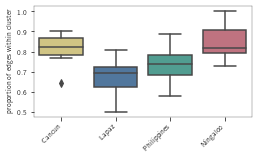

In [13]:
withinBetweenDf = pd.DataFrame([wbCanc,wbLaPaz,wbPhil,wbNing]).T
withinBetweenDf.rename(columns={0:'Cancun',1:'Lapaz',2:'Philippines',3:'Ningaloo'}, inplace=True)
withinBetweenDf = pd.melt(withinBetweenDf)

# Get the colour order
colOrder = ['rose','teal','blue','sand']

my_pal = {"Cancun": cdict.get(colOrder[3]), "Lapaz": cdict.get(colOrder[2]), 
          "Philippines":cdict.get(colOrder[1]),"Ningaloo":cdict.get(colOrder[0])}

fig, ax = plt.subplots(1,1,figsize=(0.5*fig_width,0.5*fig_height))
sns.boxplot(x='variable',y='value', data=withinBetweenDf, palette=my_pal)

ax.set(ylabel='proportion of edges within cluster', xlabel='')
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)

plt.tight_layout()
plt.show()

# fig.savefig('./figures/withinClustBoxplot_taxa.png', dpi=200)

## Get KDE estimates for each random graph

### NB Results have been saved for the impatient; they can simply be imported several cells below instead of running the bootstraps.

Here we bootstrap the kde fits using seaborn's default settings (clipping at -0.5, maxdegree). In theory it would be best to use scipy here however the scipy library did not have the clip option, and I didn't want to manually input bandwidth settings. It is slow/inefficient, decrease the number of bootstraps to <1000 to speed up.


Note that max likelihood fits gave Erdos-Renyi G(n,p) graph parameters of 0.027 for the Philippines, 0.0247 for Cancun, 0.023 for laPaz, 0.026 for Ningaloo

In [14]:
# Choose number of bootstraps
numberBoots = 5000 

# Initiate master lists
degreeDistEmpList = []
pvalAllSiteList = []
dfList = []

### Inner loop: Now generate the degree dists and KS test p-values

In [15]:
allGraphs = [G_Canc, G_phil, G_laPaz, G_ning]

# Choose graph of interest (for example G_laPaz)
# We ran in this order - 'Cancun','Philppines','Lapaz','Ningaloo'
graphToUse = allGraphs[0]

# Get the empirical degree dist
degrees = [val for (node, val) in graphToUse.degree()]

# Add to the master list
degreeDistEmpList += [degrees]

#### Generate some random graphs
Check whether an ensemble of Erdos-Renyi graphs have a significantly different degree distribution to our real-world graphs (two sample, two-tailed KS test).

Degree list has a list of lists for degree distributions for n=numboot graphs.

In [16]:
degreeList = []
pvalList = []
    
for i in range(0,numberBoots):
    degrees2, pval = get_RG_pvals_nx(graphToUse)
    degreeList += [degrees2]
    pvalList += [pval]
    
pvalAllSiteList += [pvalList]

You can use a G np graph instead if you wish for qualitatively consistent results, uncomment below. example ER param given is for lapaz

In [17]:
# ER_param = 0.023
# for i in range(0,numberBoots):
#     degrees2, pval = get_ER_pvals_nx(graphToUse,ER_param)
#     degreeList += [degrees2]
#     pvalList += [pval]

#### KDE calcs
Spits out lists of lists of the x and y co-ordinates for kde estimates on the n=numboot graphs. For example Item 0 in kdeoutx and kdeouty are the x,y coordinates for kde of the degree distribution in the 0th graph in degreeList.

In [18]:
kdeouty=[]
kdeoutx = [] 

for i in range(0,numberBoots):
    x = degreeList[i]
    x1, y = get_xyKDE(x)

    kdeouty += [list(y)]
    kdeoutx += [list(x1)]
    plt.close()

### Build the output dataframe
I want a 95% CI for the output, so here I create 60 bins across the degree range and then take the mean and sd of the KDE values in those bins. 

Obviously, the real dists have a minimum degree of zero, however we leave this as is for plotting 

In [19]:
# Create dataframe and bins (start at -1 to be sure of getting all the data)
outDf = pd.DataFrame(columns=['degree','kdeval'])
bins = np.linspace(-1,15,num=60)

# add the KDE x/y coords for each bootstrap 
for i in range(0,numberBoots):
    testDf = pd.DataFrame([kdeoutx[i],kdeouty[i]]).T.rename(columns={0:'degree',1:'kdeval'})
    s = pd.cut(testDf['degree'], bins=bins)
    testDf = testDf.groupby(s)['kdeval'].mean().reset_index()
    outDf = pd.concat([outDf,testDf])

# Take a look
outDf.head()

,degree,kdeval
0,"(-1.0, -0.729]",NaN
1,"(-0.729, -0.458]",0.053890
2,"(-0.458, -0.186]",0.075299
3,"(-0.186, 0.0847]",0.099048
4,"(0.0847, 0.356]",0.123418


In [20]:
# Get centre of bins and drop the degree coloumn

outDf['midint'] = outDf['degree'].apply(lambda x: x.mid)
outDf=outDf.dropna(axis=0, how='any')
outDfSummary = outDf.groupby('midint').mean().reset_index()
outDfSummary['stdkde'] = outDf.groupby('midint').std().reset_index()['kdeval']

# Write to the master list for plotting later
dfList += [outDfSummary]

# Take a look
outDfSummary.head()

,midint,kdeval,stdkde
0,-0.86450,NaN,NaN
1,-0.59350,0.037649,0.010897
2,-0.32200,0.056273,0.013401
3,-0.05065,0.079992,0.014780
4,0.22035,0.107071,0.013896


#### Write KDE plotting results for respective graph

In [21]:
# pkl.dump(outDfSummary, open('./data/degree_distribution/cancunKDE_RG_taxa.pkl','wb'))
# pkl.dump(outDfSummary, open('./data/degree_distribution/phillipinesKDE_RG_taxa.pkl','wb'))
# pkl.dump(outDfSummary, open('./data/degree_distribution/lapazKDE_RG_taxa.pkl','wb'))
# pkl.dump(outDfSummary, open('./data/degree_distribution/ningalooKDE_RG_taxa.pkl','wb'))

## End of inner loop - run the loop cells again on a different graph 

Next, after all 4 locations have been run, write results for the master lists for the empirical degree dists and the pvalues for KS tests against the randomised networks

In [22]:
# pkl.dump(degreeDistEmpList,open('./data/degree_distribution/degreeDistsEmpList_RG_taxa.pkl','wb'))
# pkl.dump(pvalAllSiteList,open('./data/degree_distribution/pvalAllSiteList_RG_taxa.pkl','wb'))

## For the impatient, load pre-calculated results

In [23]:
outDfSummary1 = pkl.load(open('./data/degree_distribution/cancunKDE_RG_taxa.pkl','rb'))
outDfSummary2 = pkl.load(open('./data/degree_distribution/phillipinesKDE_RG_taxa.pkl','rb'))
outDfSummary3 = pkl.load(open('./data/degree_distribution/lapazKDE_RG_taxa.pkl','rb'))
outDfSummary4 = pkl.load(open('./data/degree_distribution/ningalooKDE_RG_taxa.pkl','rb'))

degreeDistsEmpList = pkl.load(open('./data/degree_distribution/degreeDistsEmpList_RG_taxa.pkl','rb'))
pvalAllSiteList = pkl.load(open('./data/degree_distribution/pvalAllSiteList_RG_taxa.pkl','rb'))

dfList = [outDfSummary1, outDfSummary2,outDfSummary3, outDfSummary4]

## Plot the results

In [24]:
graphOrder = ['Cancun','Philppines','Lapaz','Ningaloo']
colOrder = ['rose','teal','blue','sand']

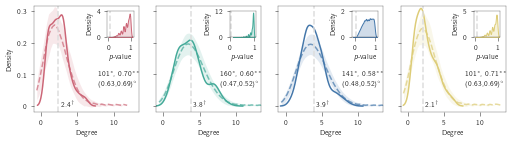

In [25]:
fig, ax1 = plt.subplots(1,4,figsize=(fig_width,0.45*fig_height))
left, bottom, width, height = [0.7, 0.71, 0.25, 0.25]

for i in range(0,4):
    ax = ax1[i]
    ax2 = ax1[i].inset_axes([left, bottom, width, height])
#     ax2 = ax.add_axes([left, bottom, width, height])

    ax.plot(dfList[i].midint.values, dfList[i].kdeval.values,
            c=cdict.get(colOrder[i]), alpha=0.7,ls='--')

    ax.fill_between(dfList[i].midint.values,dfList[i].kdeval.values-1.96*dfList[i].stdkde.values, 
                     dfList[i].kdeval.values+1.96*dfList[i].stdkde.values,
                    color=cdict.get(colOrder[i]),alpha=0.15,lw=0)

    sns.kdeplot(degreeDistsEmpList[i], clip=(-1,11), ax=ax, color=cdict.get(colOrder[i]))

    sns.kdeplot(pvalAllSiteList[i], ax=ax2, color=cdict.get(colOrder[i]), fill=True)

    ax2.axvline(x=0.05,linewidth=1.5,ls='--', color=cdict.get('pale_grey'))
    ax2.set(xlabel='$p$-value',xticks=[0,1.05], xticklabels=[0,1])
    y_min, y_max = ax2.get_ylim()
#     print(y_min,y_max)
    ax2.set(yticks=[0, math.ceil(y_max)])
    
    ax.set(xlabel='Degree',ylabel='',xlim=[-1,13.5],yticks=[0,0.1,0.2,0.3],yticklabels=[], ylim=[-0.02,0.315])
#     ax2.spines['bottom'].set_color('red')
    ax.tick_params(width=0.5)
    ax2.tick_params(width=0.5)

ax1[0].annotate(r'101$^*$, 0.70$^{**}$',(0.61,0.35),xycoords='axes fraction')
ax1[0].annotate('(0.63,0.69)$^\circ$',(0.61,0.25),xycoords='axes fraction')

ax1[0].annotate(r'2.4$^\dagger$',(2.8,0),xycoords='data')
ax1[0].axvline(x=2.4,linewidth=1.5,ls='--', color=cdict.get('pale_grey'))

ax1[1].annotate(r'160$^*$, 0.60$^{**}$',(0.61,0.35),xycoords='axes fraction')
ax1[1].annotate('(0.47,0.52)$^\circ$',(0.61,0.25),xycoords='axes fraction')

ax1[1].annotate(r'3.8$^\dagger$',(4.1,0),xycoords='data')
ax1[1].axvline(x=3.8,linewidth=1.5,ls='--', color=cdict.get('pale_grey'))

ax1[2].annotate(r'141$^*$, 0.58$^{**}$',(0.61,0.35),xycoords='axes fraction')
ax1[2].annotate('(0.48,0.52)$^\circ$',(0.61,0.25),xycoords='axes fraction')

ax1[2].annotate(r'3.9$^\dagger$',(4.2,0),xycoords='data')
ax1[2].axvline(x=3.9,linewidth=1.5,ls='--', color=cdict.get('pale_grey'))

ax1[3].annotate(r'101$^*$, 0.71$^{**}$',(0.61,0.35),xycoords='axes fraction')
ax1[3].annotate('(0.63,0.69)$^\circ$',(0.61,0.25),xycoords='axes fraction')

ax1[3].annotate(r'2.1$^\dagger$',(2.4,0),xycoords='data')
ax1[3].axvline(x=2.1,linewidth=1.5,ls='--', color=cdict.get('pale_grey'))
  
ax1[0].set(ylabel='Density')
ax1[0].set(yticks=[0,0.1,0.2,0.3],yticklabels=[0,0.1,0.2,0.3])

plt.tight_layout()
plt.show()

# fig.savefig('./figures/degreedistFig_RG_taxa.png',dpi=300)

### Node and degree stats for the empirical networks

In [26]:
print('the number of nodes in each network is')
len(np.unique(list(cancDf.columns))),len(np.unique(list(philDf.columns))),len(np.unique(list(laPazDf.columns))),len(np.unique(list(ningDf.columns)))

the number of nodes in each network is


(101, 141, 160, 108)

In [27]:
print('the average degrees of each network are')
np.mean(cancDf.sum()),np.mean(philDf.sum()),np.mean(laPazDf.sum()),np.mean(ningDf.sum())

the average degrees of each network are


(2.396039603960396, 3.8156028368794326, 3.875, 2.111111111111111)

## Code to assign network formatting attributes for import into Gephi

Utility functions

In [28]:
def getClusters_andwrite(df,graph,label):
    """ import the df for the location, its graph, and a string
    for the location that will write to file"""
    names = list(df.index)
    idx = np.arange(0,len(df.index))
    labelDict = dict(zip(idx,names))

    c = list(nx.algorithms.community.modularity_max.greedy_modularity_communities(graph))
    list(c[0])

    with open('./data/clusters/'+label+'_clusters.txt', 'w') as the_file:
        for i in range(0,len(c)):
            the_file.write(str([labelDict.get(a) for a in list(c[i])])+'\n')


def get_clustlist2(filepath):
    file1 = open(filepath, 'r')
    idx = 0
    list1 = []
    list2 = []
    for line in file1:     
#         lineList = line.rstrip('\n').split(', ') 
        lineList = line.rstrip('\n').strip(']').strip('[').split('\', ')
        lineList = [a.replace("'", "") for a in lineList]
        lineList
#         print(lineList)
        list2 += [idx] * len(lineList)
        list1 += lineList
        idx = idx + 1
    
    return list1, list2

def get_graphml(Graph, ingraphDf, locationString,abund,clusterfile):    
    # assign some attributes to a graph to export in graphml format
    
    abundP = abund[abund['location']==locationString]
    abundDict = dict(zip(abundP['family'],abundP['mean.loc.abund']))

    GraphDf = pd.DataFrame([list(ingraphDf.reset_index().index), list(ingraphDf.reset_index()['index'])]).T
    GraphDf.rename(columns={0:'Id',1:'Label'}, inplace=True)
    GraphDf['Label']=GraphDf['Label'].str.strip()
    GraphDf['meanabund'] = GraphDf['Label'].map(abundDict)
    GraphDf['logmean'] = np.log(GraphDf['meanabund'])
    
    # open clusters
    ClustDf = pd.read_csv('./data/clusters/'+clusterfile, sep='\t')
    ClustDict = dict(zip(ClustDf['family'],ClustDf['clusterID']))
    GraphDf['clusterId'] = GraphDf['Label'].map(ClustDict)
    GraphDf['clusterId'].fillna(20,inplace=True)
    GraphDf['clusterId']=GraphDf['clusterId'].astype(np.int64)
    GraphDf['color'] = GraphDf['clusterId'].map(idToCol)
    GraphDf['color'].fillna('#000000',inplace=True)
    
    # Write node label information
    GraphDf.to_csv('./results/'+locationString+'GephiNodeLabel.csv', index=False)

    # assign colours, node sizes options (mean abundance, log mean abundance, sqrt mean abundance)
    colattributedict = dict(zip(GraphDf['Id'], GraphDf['color']))
    sizeDict = dict(zip(GraphDf['Id'], GraphDf['meanabund']))
    sizeDict2 = dict(zip(GraphDf['Id'], GraphDf['logmean']))
    sizeDict3 = dict(zip(GraphDf['Id'], np.sqrt(GraphDf['meanabund'])))

    # Assign options to use in Gephi
    nx.set_node_attributes(Graph, colattributedict,'col')  
    nx.set_node_attributes(Graph, sizeDict,'size')  
    nx.set_node_attributes(Graph, sizeDict2,'logsize')  
    nx.set_node_attributes(Graph, sizeDict3,'sqrtsize')  
    nx.write_graphml(Graph, "./results/"+locationString+"_taxa.graphml" )
    
    return ClustDf, GraphDf


#### Write clusters to a file

In [29]:
# getClusters_andwrite(laPazDf,G_laPaz,'lapaz')
# getClusters_andwrite(cancDf,G_Canc,'canc')
# getClusters_andwrite(philDf,G_phil,'phil')
# getClusters_andwrite(ningDf,G_ning,'ningaloo')   

lapazClust1, l2 = get_clustlist2('./data/clusters/lapaz_clusters.txt')
cancClust1, c2 = get_clustlist2('./data/clusters/canc_clusters.txt')
philClust1, p2 = get_clustlist2('./data/clusters/phil_clusters.txt')
ningClust1, n2 = get_clustlist2('./data/clusters/ningaloo_clusters.txt')

# pd.DataFrame([lapazClust1, l2]).T.rename(columns={0:'family',1:'clusterID'}).to_csv(
#     './data/clusters/lapaz_clusters_formatted.txt', sep='\t',index=None)

# pd.DataFrame([ningClust1, n2]).T.rename(columns={0:'family',1:'clusterID'}).to_csv(
#     './data/clusters/ning_clusters_formatted.txt', sep='\t',index=None)

# pd.DataFrame([philClust1, p2]).T.rename(columns={0:'family',1:'clusterID'}).to_csv(
#     './data/clusters/phil_clusters_formatted.txt', sep='\t',index=None)

# pd.DataFrame([cancClust1, c2]).T.rename(columns={0:'family',1:'clusterID'}).to_csv(
#     './data/clusters/canc_clusters_formatted.txt', sep='\t',index=None)

#### Import abundance data, assign colours to clusters, and export in graphml format

In [30]:
# Abundance data
abund = pd.read_csv('./data/location.taxa.mean.prop.csv')

# Colours
cols = ['#CC6677', '#332288', '#DDCC77', '#117733', '#88CCEE',
        '#882255', '#44AA99', '#999933', '#AA4499', '#CCEEFF',
        '#CCDDAA','#DDDDDD','#000000']

# assign a certain number of colours 
ids = np.arange(0,13)
idToCol = dict(zip(ids,cols))

# write files

# get_graphml(G_phil,philDf,'Philippines',abund,'phil_clusters_formatted.txt')
# get_graphml(G_Canc,cancDf,'Cancun',abund,'canc_clusters_formatted.txt')
# get_graphml(G_laPaz,laPazDf,'Lapaz',abund,'lapaz_clusters_formatted.txt')
# get_graphml(G_ning,ningDf,'Ningaloo',abund,'ning_clusters_formatted.txt')